In [15]:
import urllib
from sqlalchemy import create_engine

import pandas as pd
import matplotlib.pyplot as plt
from datetime import date, timedelta
from time import time

from efficient_apriori import apriori
from matplotlib import pyplot as plt

Very_Start = time()

### DEFINITION DE TOUS LES PARAMETRES

In [16]:
# @param Does it save the figure ?
save_fig    = True
save_folder = 'UC3_fig'

# @param Connexion à la DB
driver   = '{ODBC Driver 17 for SQL Server}'
server   = 'E5591-9S6YMV2'
username = 'WVN\k.dubrulle'
login    = ('DRIVER=' + driver + 
         ';SERVER='   + server + 
         ';Trusted_Connection=yes;')

# @param Definition des table et colonnes --> Dépendent de la DB
DB            = "Archive2018_2019_prod"
TABLE_ENTETE  = "Recette_entete_ticket"
TEMPS_ENTETE  = TABLE_ENTETE             + ".TEMPS.KEY_Date_reel_de_la_transaction"
NUMERO_ENTETE = TABLE_ENTETE             + ".Numero_ticket"
TABLE_DETAIL  = "Recette_detail_ticket"
TEMPS_DETAIL  = TABLE_DETAIL             + ".TEMPS.KEY_Date_reel_transaction"
NUMERO_DETAIL = TABLE_DETAIL             + ".Numero_ticket"
TABLE_ARTICLE = "Article_meti_HIST"
TABLE_UNIVERS = "Univers"

# @param Variable influançant la sélection des données
nbr_ticket_max = 27000000  # MAX = 26.671.566 --- ~ 4 data / ticket

# @param Permet de faire varier l'analyse
min_sup     = 0.0005       # support minimum analysé  
max_sup     = 0.004        # support maximum analysé
sup_iter    = 4            # Nombre d'itération - 1 fait sur la variantion de support
min_conf    = 0.2          # confiance minimum analysée
max_conf    = 0.7          # confiance maximum analysée
conf_iter   = 5            # Nombre d'itération - 1 fait sur la variantion de confiance
do_analysis = False        # Est-ce qu'on fait l'analyse ou non ? 

# @param du modèle prédictif
min_support    = 1/500     # Seuil de support minimal souhaité   -> 1/#univers ~= 1/500
min_confidence = 1/3       # Seuil de confiance minimal souhaité -> 1/3        ~= 33% 

In [17]:
# TEST Connexion
params = urllib.parse.quote_plus(login)
engine = create_engine("mssql+pyodbc:///?odbc_connect=%s" % params)

conn = engine.connect()

df = pd.read_sql("SELECT TOP(10) ["+TABLE_ARTICLE+".KEY] FROM ["+DB+"].[DWH].[Dim_"+TABLE_ARTICLE+"]", conn)
print(df)

conn.close()

   Article_meti_HIST.KEY
0                     -1
1                      1
2                      2
3                      3
4                      4
5                      5
6                      6
7                      7
8                      8
9                      9


# GROUPEMENT D'ARTICLE

In [18]:
def date_to_key(d):
    return d.year*10000 + d.month*100 + d.day

start = time()

sql_command = '''SELECT [''' + TABLE_ARTICLE + '''.''' + TABLE_UNIVERS + '''.KEY],
['''     + TABLE_ENTETE  + '''.KEY]
FROM ['''       + DB + '''].[DWH].[Dim_'''  + TABLE_ARTICLE   + ''']
INNER JOIN [''' + DB + '''].[DWH].[Fact_''' + TABLE_DETAIL    + ''']
ON ['''  + TABLE_ARTICLE + '''.KEY] = ['''  + TABLE_DETAIL    + '''.''' + TABLE_ARTICLE + '''.KEY]
INNER JOIN [''' + DB + '''].[DWH].[Fact_''' + TABLE_ENTETE    + '''] 
ON ['''  + TEMPS_DETAIL  + '''] = ['''      + TEMPS_ENTETE    + '''] 
AND [''' + NUMERO_DETAIL + '''] = ['''      + NUMERO_ENTETE   + ''']
WHERE ['''    + TABLE_ARTICLE + '''.'''     + TABLE_UNIVERS   + '''.KEY] != -1 
AND ['''      + TABLE_ENTETE  + '''.Nombre_articles] > 0 
AND ['''      + TABLE_ENTETE  + '''.KEY] < ''' + str(nbr_ticket_max) + '''
AND [''' + TABLE_ARTICLE + '''.''' + TABLE_UNIVERS + '''.KEY] != 388
ORDER BY [''' + TABLE_ENTETE  + '''.KEY]'''

print(sql_command)

conn = engine.connect()
df_art_ticket = pd.read_sql(sql_command, conn)
conn.close()

# environ 3min
print("Time Taken to load DB: ~" + str(int(time() - start)) + "secondes") 
nbr_data = len(df_art_ticket)
print(df_art_ticket)

SELECT [Article_meti_HIST.Univers.KEY],
[Recette_entete_ticket.KEY]
FROM [Archive2018_2019_prod].[DWH].[Dim_Article_meti_HIST]
INNER JOIN [Archive2018_2019_prod].[DWH].[Fact_Recette_detail_ticket]
ON [Article_meti_HIST.KEY] = [Recette_detail_ticket.Article_meti_HIST.KEY]
INNER JOIN [Archive2018_2019_prod].[DWH].[Fact_Recette_entete_ticket] 
ON [Recette_detail_ticket.TEMPS.KEY_Date_reel_transaction] = [Recette_entete_ticket.TEMPS.KEY_Date_reel_de_la_transaction] 
AND [Recette_detail_ticket.Numero_ticket] = [Recette_entete_ticket.Numero_ticket]
WHERE [Article_meti_HIST.Univers.KEY] != -1 
AND [Recette_entete_ticket.Nombre_articles] > 0 
AND [Recette_entete_ticket.KEY] < 27000000
AND [Article_meti_HIST.Univers.KEY] != 388
ORDER BY [Recette_entete_ticket.KEY]
Time Taken to load DB: ~1067secondes
          Article_meti_HIST.Univers.KEY  Recette_entete_ticket.KEY
0                                   392                          2
1                                   148                        

In [19]:
transactions = []
key_ticket = -1
for item in df_art_ticket.values:
    if key_ticket != item[1]:
        if key_ticket != -1:
            transactions.append(tuple(l))
        key_ticket = item[1]
        if not key_ticket%int(nbr_ticket_max/10):
            print(key_ticket*100/nbr_ticket_max,"%")
        l = []
    l.append(item[0])
transactions.append(tuple(l))
print(transactions[:20])

10.0 %
20.0 %
30.0 %
50.0 %
60.0 %
70.0 %
90.0 %
[(392, 148, 148), (129, 357, 392, 174, 69, 294, 183), (358, 393, 457, 393), (357, 400, 129), (456, 394, 394, 110, 468), (299, 148, 357), (299, 437), (219, 452, 477, 477, 319, 396, 121), (299, 299), (148, 400, 148, 400), (176, 212), (403, 403, 148, 148, 403, 148, 148, 148), (357, 457, 409), (251, 211, 409), (393, 148, 272), (294, 392, 121, 457), (392, 331, 470, 418), (272, 392, 361, 231, 231, 151), (129, 403, 120, 392, 457), (297, 272, 294)]


In [20]:
univ_max = max(df_art_ticket[TABLE_ARTICLE + "."+TABLE_UNIVERS+".KEY"])
rec_article = [0 for _ in range(univ_max)]
N = len(transactions)
for art in df_art_ticket[TABLE_ARTICLE + "."+TABLE_UNIVERS+".KEY"]:
    rec_article[art-1]+=1
for i in range(univ_max):
    rec_article[i]/= N
print(N)

20292100


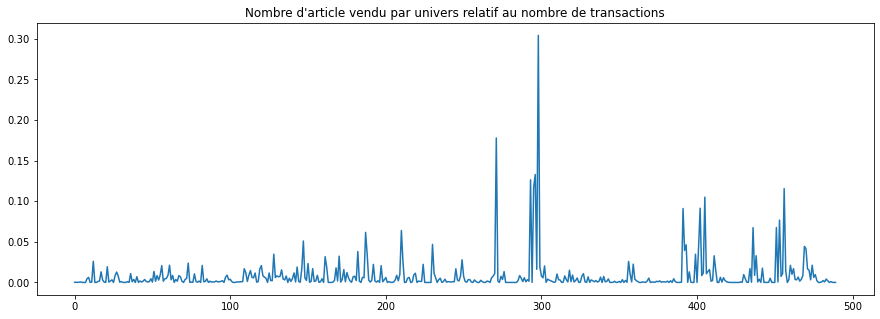

In [21]:
fig = plt.figure(figsize=(15, 5))
plt.plot(rec_article)
plt.title("Nombre d'article vendu par univers relatif au nombre de transactions")
    
if save_fig:
    plt.savefig(save_folder+"/Proportion-Article.jpg")
plt.show()

In [22]:
if do_analysis:
    data_rules = {}
    data_time  = {}
    for i_support in range(sup_iter+1):
        min_support = max_sup - i_support*(max_sup-min_sup)/sup_iter

        if min_support <= 0:
            break

        print(min_support, end = ': ')

        data_rules[min_support] = {}
        data_time[min_support]  = {}
        for i_confidence in range(conf_iter+1):
            min_confidence = max_conf - i_confidence*(max_conf-min_conf)/conf_iter

            print(min_confidence, end = '... ')

            start = time()
            _, rules = apriori(transactions, min_support=min_support, min_confidence=min_confidence)

            data_rules[min_support][min_confidence] = len(rules)
            data_time[min_support][min_confidence]  = int(time() - start)

        print(sum(data_time[min_support].values()), "secondes")


    df_rules = pd.DataFrame(data_rules)
    print(df_rules)
    df_time = pd.DataFrame(data_time)
    print(df_time)

In [23]:
start = time()

_, rules = apriori(transactions, min_support=min_support, min_confidence=min_confidence)

print(len(rules))
for rule in sorted(rules, key=lambda rule: rule.lift):
    print(rule)

# eniviron 30s*0.002/min_sup * #transactions / 2.500.000     
print("Time Taken to run Apriori Algorithm : ~" + str(int(time() - start)) + "secondes") 

11
{438} -> {299} (conf: 0.380, supp: 0.003, lift: 2.554, conv: 1.373)
{437} -> {299} (conf: 0.388, supp: 0.020, lift: 2.605, conv: 1.390)
{301} -> {299} (conf: 0.455, supp: 0.003, lift: 3.056, conv: 1.562)
{439} -> {299} (conf: 0.481, supp: 0.014, lift: 3.229, conv: 1.639)
{271} -> {272} (conf: 0.521, supp: 0.005, lift: 3.462, conv: 1.774)
{74} -> {294} (conf: 0.368, supp: 0.007, lift: 3.855, conv: 1.431)
{27} -> {294} (conf: 0.423, supp: 0.003, lift: 4.439, conv: 1.569)
{437, 439} -> {299} (conf: 0.708, supp: 0.003, lift: 4.759, conv: 2.920)
{448} -> {297} (conf: 0.961, supp: 0.005, lift: 8.749, conv: 22.735)
{408} -> {402} (conf: 0.353, supp: 0.004, lift: 10.232, conv: 1.492)
{56} -> {183} (conf: 0.341, supp: 0.002, lift: 12.512, conv: 1.477)
Time Taken to run Apriori Algorithm : ~271secondes


In [24]:
conn = engine.connect()

for rule in sorted(rules, key=lambda rule: rule.lift):
    print("\n\nRule : ", rule)
    
    sql_command = '''SELECT [''' + TABLE_UNIVERS  + '''.KEY] AS Univ_KEY, 
    ['''  + TABLE_UNIVERS  + '''.Libelle_univers1_FR] AS Univ_1 
    ,[''' + TABLE_UNIVERS  + '''.Libelle_univers2_FR] AS Univ_2 
    ,[''' + TABLE_UNIVERS  + '''.Libelle_univers3_FR] AS Univ_3 
    ,[''' + TABLE_UNIVERS  + '''.Libelle_univers4_FR] AS Univ_4 
    FROM ['''+DB+'''].[DWH].[Dim_'''+TABLE_UNIVERS+''']
    WHERE '''
    for v in rule.lhs:
        sql_command += "[" + TABLE_UNIVERS  + ".KEY] = " + str(v) + "\nOR "
    sql_command = sql_command[:-3]

    df_libele = pd.read_sql(sql_command, conn)
    
    print(df_libele.to_string(index=False))
    print('->')
    
    sql_command = '''SELECT [''' + TABLE_UNIVERS  + '''.KEY] AS Univ_KEY, 
    ['''  + TABLE_UNIVERS  + '''.Libelle_univers1_FR] AS Univ_1 
    ,[''' + TABLE_UNIVERS  + '''.Libelle_univers2_FR] AS Univ_2 
    ,[''' + TABLE_UNIVERS  + '''.Libelle_univers3_FR] AS Univ_3 
    ,[''' + TABLE_UNIVERS  + '''.Libelle_univers4_FR] AS Univ_4 
    FROM ['''+DB+'''].[DWH].[Dim_'''+TABLE_UNIVERS+''']
    WHERE '''
    for v in rule.rhs:
        sql_command += "[" + TABLE_UNIVERS  + ".KEY] = " + str(v) + "\nOR "
    sql_command = sql_command[:-3]

    df_libele = pd.read_sql(sql_command, conn)
    
    print(df_libele.to_string(index=False))

conn.close()



Rule :  {438} -> {299} (conf: 0.380, supp: 0.003, lift: 2.554, conv: 1.373)
 Univ_KEY   Univ_1    Univ_2        Univ_3        Univ_4
      438 BOISSONS JUS ZUMEX JUS ZUMEX >1P JUS ZUMEX >1P
->
 Univ_KEY         Univ_1       Univ_2        Univ_3        Univ_4
      299 PETIT DEJEUNER VIENNOISERIE VIENNOISERIES VIENNOISERIES


Rule :  {437} -> {299} (conf: 0.388, supp: 0.020, lift: 2.605, conv: 1.390)
 Univ_KEY         Univ_1       Univ_2       Univ_3       Univ_4
      437 PETIT DEJEUNER CAFE SERVICE CAFE SERVICE CAFE SERVICE
->
 Univ_KEY         Univ_1       Univ_2        Univ_3        Univ_4
      299 PETIT DEJEUNER VIENNOISERIE VIENNOISERIES VIENNOISERIES


Rule :  {301} -> {299} (conf: 0.455, supp: 0.003, lift: 3.056, conv: 1.562)
 Univ_KEY         Univ_1            Univ_2           Univ_3           Univ_4
      301 PETIT DEJEUNER PRODUITS LAITIERS LAITS CHOCOLATES LAITS CHOCOLATES
->
 Univ_KEY         Univ_1       Univ_2        Univ_3        Univ_4
      299 PETIT DEJEUNER VIENNO

In [25]:
print("Total Time Taken: ~" + str(int(time() - Very_Start)) + "secondes") 

Total Time Taken: ~1437secondes
